In [2]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from stable_baselines.sac.policies import MlpPolicy as MlpSACPolicy
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv, VecEnv
from stable_baselines import A2C, PPO2, SAC

import envs.portfolio
import envs.portfolio_distributions

import importlib
importlib.reload( envs.portfolio )
importlib.reload( envs.portfolio_distributions )
from envs.portfolio import PortfolioEnv

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
def create_custom_env():
    n_risky_assets=1
    objective='total-wealth'
    benchmark_weights=None
    utility_fun=envs.portfolio_distributions.ExponentialUtilityFunction(alpha=2)
    trans_costs=0.0
    min_short=0.0
    max_long=1.0
    n_periods_per_year=12
    is_recurrent=True
    asset_process_name='lognormal-static'
    
    # Set a custom asset process, with a custom probability distribution on the assets
    # Get the parameters for a lognormal distribution with the desired properties
    asset_process = envs.portfolio_distributions.LognormalStaticProcess( 
                                               np_random = np.random.RandomState(np.random.choice(1000)), 
                                               n_risky_assets=1, 
                                               n_periods_per_year=n_periods_per_year )
    eq_risk_premium = -0.02
    ann_vol = 0.15
    distrib_params = dict( mu=[eq_risk_premium], sigma=[[ann_vol ** 2]] )
    asset_process.set_distribution(distrib_params)
    
    env = PortfolioEnv(
                        n_risky_assets=n_risky_assets,
                        objective=objective,
                        benchmark_weights=benchmark_weights,
                        utility_fun=utility_fun,
                        trans_costs=trans_costs,
                        min_short=min_short,
                        max_long=max_long,
                        n_periods_per_year=n_periods_per_year,
                        is_recurrent=is_recurrent,
                        asset_process=asset_process
                      )
    return env

In [3]:
def create_custom_env():
    n_risky_assets=1
    utility_fun=envs.portfolio_distributions.ExponentialUtilityFunction(alpha=2)
    trans_costs=0.0
    min_short=0.0
    max_long=1.0
    n_periods_per_year=12
    is_recurrent=True
    
    env = PortfolioEnv(
                        n_risky_assets=n_risky_assets,
                        utility_fun=utility_fun,
                        trans_costs=trans_costs,
                        min_short=min_short,
                        max_long=max_long,
                        n_periods_per_year=n_periods_per_year,
                        is_recurrent=is_recurrent
                      )
    return env

In [ ]:
asset_process = envs.portfolio_distributions.LognormalStaticProcess( 
                                           np_random = np.random.RandomState(np.random.choice(1000)), 
                                           n_risky_assets=1, 
                                           n_periods_per_year=12 )
eq_risk_premium = 0.04
ann_vol = 0.15
distrib_params = dict( mu=[eq_risk_premium], sigma=[[ann_vol ** 2]] )
asset_process.set_distribution(distrib_params)

In [ ]:
ann_log_rtns = np.log( np.product( 1 + asset_process.distrib.random(1200000).reshape(-1,12), axis=1 ) )
ann_arith_rtns = -1 + np.exp( ann_log_rtns )
plt.hist( ann_arith_rtns, 50 )
[ ann_log_rtns.mean(), ann_log_rtns.std() ]

In [ ]:
n_samples = int(1e6)
mu = 0.02
vol = 0.15

wt_vals = np.arange( 0, 1.001, 0.01)
u_vals = []
sampled_rtns = np.random.multivariate_normal( [mu], [[vol ** 2]], size=(n_samples,) )
for w in wt_vals:
    u_val = np.mean( utility_fun(w * sampled_rtns) )
    u_vals.append(u_val)
    
plt.plot( wt_vals, u_vals )

In [18]:
learning_rate = 0.0001
act_fun = tf.tanh
nminibatches = 4

env_init_fun = lambda : create_custom_env()
env = DummyVecEnv( [ env_init_fun for _ in range(nminibatches) ]  )

is_recurrent = env.envs[0].is_recurrent
utility_fun = env.envs[0].utility_fun
    
if is_recurrent:
    net_arch=[ 32, 'lstm', dict( pi=[32],
                                 vf=[32] ) ]
    policy_kwargs=dict( act_fun=act_fun, net_arch=net_arch )
    model = PPO2( MlpLstmPolicy, 
                  env, 
                  gamma=1.0,
                  policy_kwargs=policy_kwargs,
                  learning_rate=learning_rate,
                  nminibatches=nminibatches,
                  verbose=0 )    
else:
    net_arch = net_arch=[ 32, dict( pi=[32],
                                    vf=[32] ) ]
    net_arcn = [ 32, 32 ]
    policy_kwargs=dict( act_fun=act_fun,
                        net_arch=net_arch )
    
    model = PPO2( MlpPolicy, 
                  env, 
                  policy_kwargs=policy_kwargs,
                  gamma = env.envs[0].get_gamma(),
                  learning_rate=learning_rate,
                  nminibatches=nminibatches,
                  verbose=0 )

In [19]:
%%time
model.learn(total_timesteps=int(2e5) )

CPU times: user 26min 57s, sys: 16min 6s, total: 43min 3s
Wall time: 10min 59s


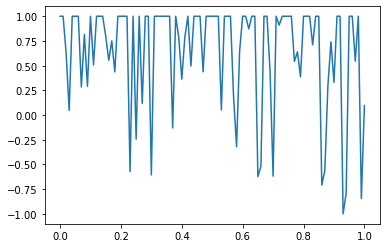

In [20]:
mu = -0.02
sigma = 0.15

wt_vals = np.arange( 0, 1.001, 0.01)
vals = []

for mv_1 in wt_vals:
    mv_0 = 1 - mv_1
    if is_recurrent:
        state = np.tile( np.array( [ mv_0, mv_1, mu, sigma ], dtype=np.float32 ), (nminibatches, 1) )
    else:
        state = np.array( [ 0.0, mv_0, mv_1, mu, sigma ], dtype=np.float32 )

    action, next_state = model.predict(state)
    if is_recurrent:
        vals.append( action[0,:] )
    else:
        vals.append( action ) 

plt.plot(wt_vals, vals )    

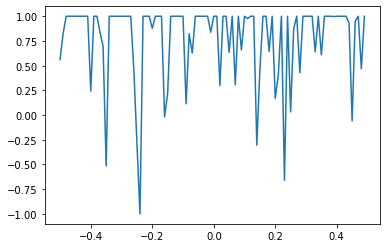

In [21]:
risky_wt = 0.
sigma = 0.15

mu_vals = np.arange( -.5, .5, 0.01)
vals = []

for mu in mu_vals:
    if is_recurrent:
        state = np.tile( np.array( [ 1 - risky_wt, risky_wt, mu, sigma ], dtype=np.float32 ), (nminibatches, 1) )
    else:
        state = np.array( [ 0.0, 1 - risky_wt, risky_wt, mu, sigma ], dtype=np.float32 )

    action, next_state = model.predict(state)
    if is_recurrent:
        vals.append( action[0,:] )
    else:
        vals.append( action ) 

plt.plot(mu_vals, vals )    

In [14]:
def play_game(env, policy_func, gamma=1.0):
    obs = env.reset()
    tot_reward = 0
    done = False
    while not done:
        state = obs
        action = policy_func(state)
        obs, reward, done, info = env.step(action)
        tot_reward = gamma * tot_reward + reward
    return tot_reward

In [ ]:
scores = []
tmp_env = create_custom_env()
gm = tmp_env.get_gamma()
x_vals = np.arange(0, 1.001, 0.05 )
for x in x_vals:
    policy_func = lambda state : np.array( [x], dtype=np.float32 )
    avg_scores = []
    for _ in range(10):
        score = play_game( env=tmp_env, policy_func=policy_func, gamma=gm)
        avg_scores.append(score)
    scores.append(np.mean(avg_scores))
plt.plot( x_vals, scores )    

In [ ]:
tmp_env.reset()
#tmp_env.step(np.array([1.]) )

In [ ]:
xx = np.arange(0.5, 2, 0.01 )
etas = [ 0, 1, 2, 3 ]
for eta in etas:
    u_vals = []
    u_func = envs.portfolio_distributions.PowerUtilityFunction(eta=eta)
    for x in xx:
        u1 = u_func(x)
        gm = env.envs[0].get_gamma()
        u_vals.append(u1)

    plt.plot(xx, u_vals )
    
plt.legend(etas)

In [ ]:
done = False
obs = env.reset()
mv_0 = obs[1] + obs[2]
tot_rewards = 0
while not done:
    obs, reward, done, info = env.step( np.array([ 0.]) )
    tot_rewards += np.exp(reward)
mv_F = obs[1] + obs[2]
print([ -1 + mv_F / mv_0, tot_rewards ] )

In [ ]:
[ info, env.get_gamma() ]

In [ ]:
1 / np.power( 1 + env.asset_process.risk_free_rate, 1 / env.n_periods_per_year )

In [ ]:
def get_weights_from_unit_cube( array_vals ):
    gamma_vals = scipy.stats.gamma.ppf( array_vals, a=1. )
    norm_factor = gamma_vals.sum(axis=1, keepdims=True)
    weights = gamma_vals / norm_factor
    return weights, norm_factor

def get_unit_cube_from_weights( weights, norm_factor ):
    gamma_vals = weights * norm_factor
    array_vals = scipy.stats.gamma.cdf( gamma_vals, a=1. )
    return array_vals